In [27]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from thop import profile

In [28]:
# === DeepDehazeNet Definition ===
class DeepDehazeNet(nn.Module):
    def __init__(self, layers=8):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2)
            )
        self.layers = layers
        if layers == 4:
            self.enc1 = conv_block(3, 64)
            self.pool1 = nn.MaxPool2d(2)
            self.bottleneck = conv_block(64, 128)
            self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
            self.dec1 = conv_block(128, 64)
            self.final = nn.Conv2d(64, 3, 1)
        elif layers == 8:
            self.enc1 = conv_block(3, 64)
            self.pool1 = nn.MaxPool2d(2)
            self.enc2 = conv_block(64, 128)
            self.pool2 = nn.MaxPool2d(2)
            self.enc3 = conv_block(128, 256)
            self.pool3 = nn.MaxPool2d(2)
            self.bottleneck = conv_block(256, 512)
            self.up1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
            self.dec1 = conv_block(512, 256)
            self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
            self.dec2 = conv_block(256, 128)
            self.up3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
            self.dec3 = conv_block(128, 64)
            self.final = nn.Conv2d(64, 3, 1)
        elif layers == 16:
            self.enc1 = conv_block(3, 64)
            self.pool1 = nn.MaxPool2d(2)
            self.enc2 = conv_block(64, 128)
            self.pool2 = nn.MaxPool2d(2)
            self.enc3 = conv_block(128, 256)
            self.pool3 = nn.MaxPool2d(2)
            self.enc4 = conv_block(256, 512)
            self.pool4 = nn.MaxPool2d(2)
            self.enc5 = conv_block(512, 1024)
            self.pool5 = nn.MaxPool2d(2)
            self.bottleneck = conv_block(1024, 2048)
            self.up1 = nn.ConvTranspose2d(2048, 1024, 2, stride=2)
            self.dec1 = conv_block(2048, 1024)
            self.up2 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
            self.dec2 = conv_block(1024, 512)
            self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
            self.dec3 = conv_block(512, 256)
            self.up4 = nn.ConvTranspose2d(256, 128, 2, stride=2)
            self.dec4 = conv_block(256, 128)
            self.up5 = nn.ConvTranspose2d(128, 64, 2, stride=2)
            self.dec5 = conv_block(128, 64)
            self.final = nn.Conv2d(64, 3, 1)

    def forward(self, x):
        if self.layers == 4:
            e1 = self.enc1(x)
            b = self.bottleneck(self.pool1(e1))
            d1 = self.dec1(torch.cat([self.up1(b), e1], 1))
            return torch.sigmoid(self.final(d1))
        elif self.layers == 8:
            e1 = self.enc1(x)
            e2 = self.enc2(self.pool1(e1))
            e3 = self.enc3(self.pool2(e2))
            b = self.bottleneck(self.pool3(e3))
            d1 = self.dec1(torch.cat([self.up1(b), e3], 1))
            d2 = self.dec2(torch.cat([self.up2(d1), e2], 1))
            d3 = self.dec3(torch.cat([self.up3(d2), e1], 1))
            return torch.sigmoid(self.final(d3))
        elif self.layers == 16:
            e1 = self.enc1(x)
            e2 = self.enc2(self.pool1(e1))
            e3 = self.enc3(self.pool2(e2))
            e4 = self.enc4(self.pool3(e3))
            e5 = self.enc5(self.pool4(e4))
            b = self.bottleneck(self.pool5(e5))
            d1 = self.dec1(torch.cat([self.up1(b), e5], 1))
            d2 = self.dec2(torch.cat([self.up2(d1), e4], 1))
            d3 = self.dec3(torch.cat([self.up3(d2), e3], 1))
            d4 = self.dec4(torch.cat([self.up4(d3), e2], 1))
            d5 = self.dec5(torch.cat([self.up5(d4), e1], 1))
            return torch.sigmoid(self.final(d5))


In [29]:
# === Compute GFLOPs and Params ===
dummy_input = torch.randn(1, 3, 256, 256)
results = {}

for layers in [4, 8, 16]:
    model = DeepDehazeNet(layers).eval()
    flops, params = profile(model, inputs=(dummy_input,), verbose=False)
    gflops = flops / 1e9
    mparams = params / 1e6
    results[f"{layers} Layers"] = (gflops, mparams)


In [30]:
# === Print Table ===
print("\n✅ GFLOPs and Parameters for DeepDehazeNet:\n")
print(f"{'Model':<12} {'GFLOPs':>10} {'Params (M)':>12}")
print("-" * 36)
for name, (gflop, mparam) in results.items():
    print(f"{name:<12} {gflop:10.2f} {mparam:12.2f}")


✅ GFLOPs and Parameters for DeepDehazeNet:

Model            GFLOPs   Params (M)
------------------------------------
4 Layers           8.36         0.18
8 Layers          24.75         3.79
16 Layers         41.13        61.48


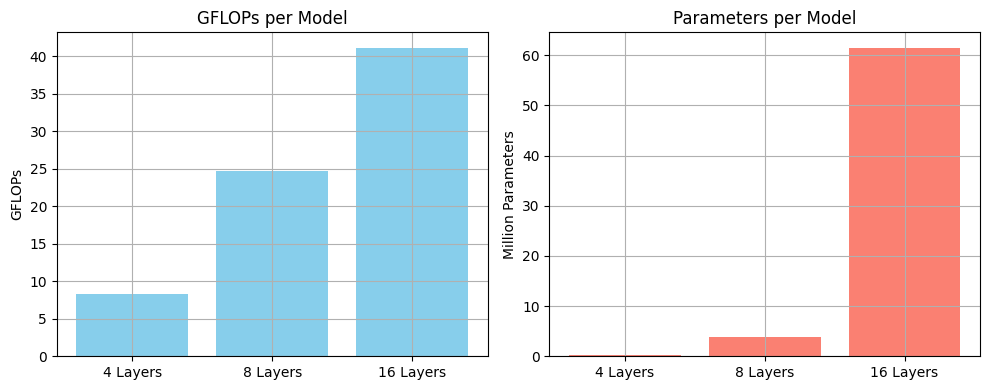

In [31]:
# === Plot Charts ===
labels = list(results.keys())
gflops = [results[k][0] for k in labels]
params = [results[k][1] for k in labels]

plt.figure(figsize=(10, 4))

# GFLOPs bar plot
plt.subplot(1, 2, 1)
plt.bar(labels, gflops, color='skyblue')
plt.title("GFLOPs per Model")
plt.ylabel("GFLOPs")
plt.grid(True)

# Params bar plot
plt.subplot(1, 2, 2)
plt.bar(labels, params, color='salmon')
plt.title("Parameters per Model")
plt.ylabel("Million Parameters")
plt.grid(True)

plt.tight_layout()
plt.show()
